In [2]:
from math import exp, sqrt, sin, cos
import itertools

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.optimize import fsolve
from mpl_toolkits import mplot3d

## Konstante i osnovne funkcije

In [13]:
kb = 8.6173303 * 10**(-5)
hbar = 6.582119569*10**(-16)
pi = np.pi

alpha_op = 0.6
alpha_ac = 0.2
hbar_w_op = 0.02
eta_0 = 5 * 10**(-3) # min=0.3 meV
M = 0.05
Kf = 0.25 # eV
vf = 5 * 10**5
a = 100**(1/3) * 10**(-10)
T_0 = 50

Ef = sqrt(Kf**2 + M**2)
Kf_ = Kf / hbar / vf * a # unitless
Kf_max = 6 * Kf_
hbar_w_ac = 0.01 / Kf_max
G_op2 = alpha_op
G_ac2 = alpha_ac * hbar * vf / a

print(G_ac2)
print(hbar_w_ac)
print(Ef)


0.1418074673339131
0.0047269155777971035
0.25495097567963926


In [30]:
def fermi_dirac(E, Ef, T): 
    if T > 0:
       if E > Ef:
           return exp((-E + Ef) / (kb * T)) / (exp((-E + Ef) / (kb * T)) + 1)
       else:
           return 1 / (exp((E - Ef) / (kb * T)) + 1)
    else:
        if E < Ef: 
            return 0 
        else: 
            return 1

def bose_einstein(E,T): 
    assert T > 0
    return exp(-E / (kb * T)) / (-exp(-E / (kb * T)) + 1)

def chemical_potential(T):
#     return Ef - pi**2 / 6 * (2 * Ef**2 - M**2) / Ef / (Ef**2 - M**2) * (kb * T)**2 - 7 / 360 * pi**4 * 3 * M**4 / Ef / (Ef**2 - M**2)**3 * (kb * T)**4
    return abs(fsolve(particle_density_int, 0.55,args=(M,Kf,T)))

def particle_density(E,Ef,M,T):
    g=E*sqrt(E**2-M**2)/pi**2/(hbar*vf)**3
    fs=-fermi_dirac(E,-Ef,T)+fermi_dirac(E,Ef,T)
    return g*fs

def particle_density_int(u,M,Kf,T):
    na=1/3/pi**2*Kf**3/(vf*hbar)**3
    return na-integrate.quad(particle_density ,M,2,args=(u,M,T),limit=80000)[0]


def eps(K):
    return sqrt(hbar**2 * vf**2 / a**2 * K**2 + M**2)

# for t in range(0,5000,10):
#     plt.scatter(t, abs(fsolve(particle_density_int, 0.55,args=(M,Kf,t))))

## Optički fononi


In [23]:
def ss_sum_part(K, hbar_w, hbar_w_ph, T, u, eta):
    def summand(s1, s2):
        return ((bose_einstein(hbar_w_ph, T) + fermi_dirac(s1 * s2 * eps(K), s1 * s2 * u, T)) / (hbar_w + s1 * Ef - s1 * eps(K) + s2 * hbar_w_ph + eta * 1j))
    sum = 0
    for s1, s2 in itertools.product([-1, 1], [-1, 1]):
        sum = sum + summand(s1, s2)
    return sum * K**2

def ss_sum_real(K, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part(K, hbar_w, hbar_w_ph, T, u, eta).real

def ss_sum_imag(K, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part(K, hbar_w, hbar_w_ph, T, u, eta).imag

def mem_fn(ss_sum_fn, hbar_w, hbar_w_ph, u, T, eta):    
    integral_k = integrate.quad(ss_sum_fn, 0, Kf_*7, args=(hbar_w, hbar_w_ph, T, u, eta), limit=80000)[0]
    return -G_op2 * integral_k / (2*pi)**2 * 2


**Memorijska funkcija**

In [28]:
ws_0 = np.arange(0, 0.3, 0.001)

def calculate_integral_points(mem_fn, T=T_0, eta=eta_0, ws=ws_0):
    result_real = []
    result_imag = []
    for w in ws:
        result_real.append(mem_fn(ss_sum_real, hbar_w=w, hbar_w_ph=hbar_w_op, u=chemical_potential(T), T=T, eta=eta))
        result_imag.append(mem_fn(ss_sum_imag, hbar_w=w, hbar_w_ph=hbar_w_op, u=chemical_potential(T), T=T, eta=eta))
    return result_real, result_imag

def setup_plot(real=True, imag=True, x_lim=[0.0, 0.3], y_lim=[0.0, 0.4]):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel(r"$\hbar \omega [eV]$" )
    if real:
        ax1.set_ylabel(r"$\hbar Re\{M_x\} [eV]$" )
    else:
        ax1.set_ylabel(r"$\hbar Im\{M_x\} [eV]$" )
    ax1.set_xlim(x_lim)
    ax1.set_ylim(y_lim)

    ax2 = ax1.twinx()
    if imag and real:
        ax2.set_ylabel(r"$\hbar Im\{M_x\} [eV]$" )
    ax2.set_xlim(x_lim)
    ax2.set_ylim(y_lim)

    return fig, ax1, ax2
    

def plot_real_and_imag_result(ax1, ax2, result_real, result_imag, T=None, eta=None, ws=ws_0):
    assert T or eta
    ax1.plot(ws, result_real, label=f"T={T} K" if T else f"$\eta = $ {eta:.4f} eV")
    ax2.plot(ws, result_imag)
    if T:
        plt.text(0.020, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)
    else:
        plt.text(0.020, 0.002 , f"T={T_0} K" , fontsize =10)

def plot_result(ax, result, T=None, eta=None, ws=ws_0):
    ax.plot(ws, result, label=f"T={T} K" if T else f"$\eta = $ {eta:.5f} eV")


/var/folders/44/lysn_6ln17l7jh0rqmrtwt0m0000gn/T/ipykernel_50663/1602644981.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return exp((-E + Ef) / (kb * T)) / (exp((-E + Ef) / (kb * T)) + 1)
/var/folders/44/lysn_6ln17l7jh0rqmrtwt0m0000gn/T/ipykernel_50663/1602644981.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (exp((E - Ef) / (kb * T)) + 1)


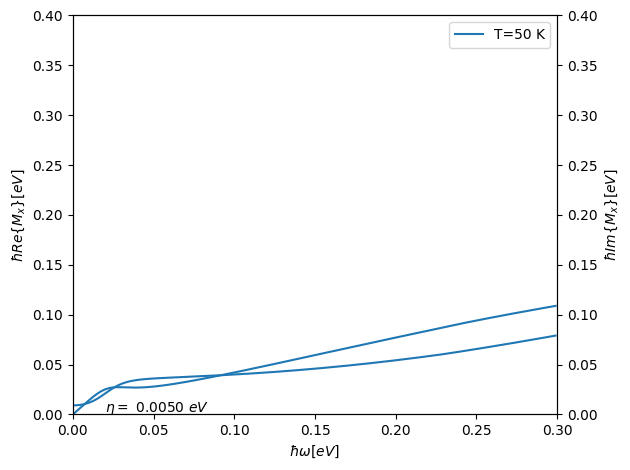

In [31]:
fig, *axs = setup_plot()
integrals = calculate_integral_points(mem_fn)
plot_real_and_imag_result(*axs, *integrals, T=T_0)
axs[0].legend(loc="best")
fig.tight_layout()

/var/folders/44/lysn_6ln17l7jh0rqmrtwt0m0000gn/T/ipykernel_50663/1602644981.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return exp((-E + Ef) / (kb * T)) / (exp((-E + Ef) / (kb * T)) + 1)
/var/folders/44/lysn_6ln17l7jh0rqmrtwt0m0000gn/T/ipykernel_50663/1602644981.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (exp((E - Ef) / (kb * T)) + 1)


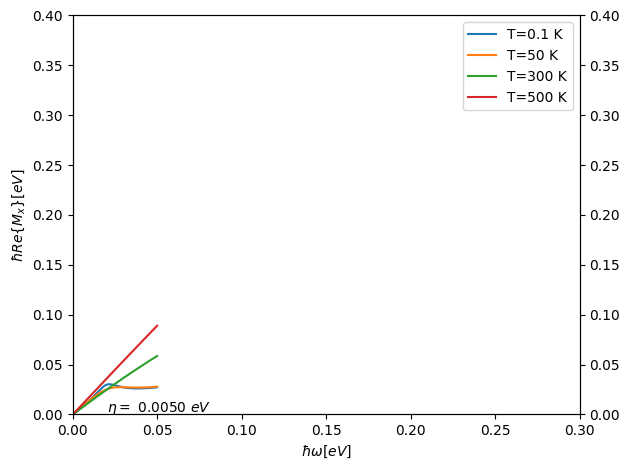

In [32]:
fig, *axs = setup_plot(imag=False)
for T in [0.1, 50, 300, 500]:
    integrals = calculate_integral_points(mem_fn, T=T, ws= np.arange(0, 0.05, 0.0001))
    plot_result(axs[0], integrals[0], T=T, ws= np.arange(0, 0.05, 0.0001))
axs[0].legend(loc="best")
plt.text(0.020, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)
fig.tight_layout()

<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Patrik\AppData\Local\Temp\ipykernel_11452\1992963086.py:6: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.020, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)


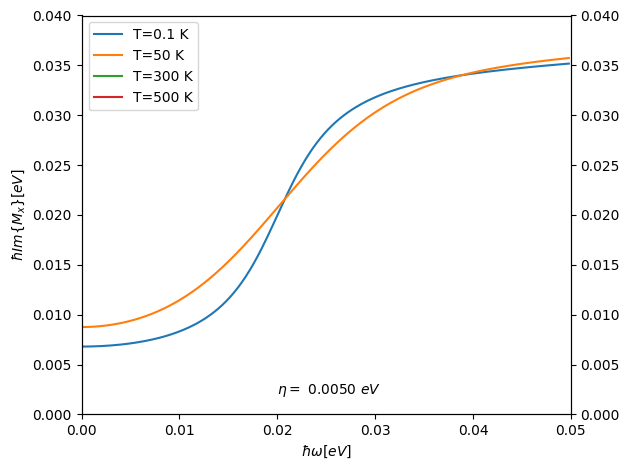

In [62]:
fig, *axs = setup_plot(real=False)
for T in [0.1, 50, 300, 500]:
    integrals = calculate_integral_points(mem_fn, T=T)
    plot_result(axs[0], integrals[1], T=T)
axs[0].legend(loc="best")
plt.text(0.020, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)
fig.tight_layout()

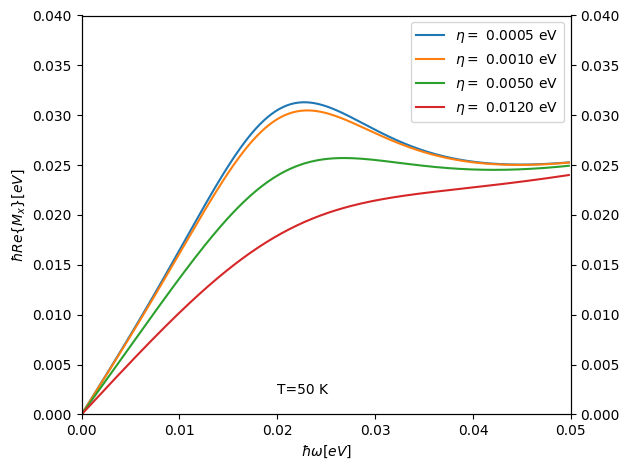

In [64]:
fig, *axs = setup_plot(imag=False)
for eta in [0.0005, 0.001, 0.005, 0.012]:
    integrals = calculate_integral_points(mem_fn, eta=eta)
    plot_result(axs[0], integrals[0], eta=eta)
axs[0].legend(loc="best")
plt.text(0.020, 0.002 , f"T={T_0} K" , fontsize =10)
fig.tight_layout()

C:\Users\Patrik\AppData\Local\Temp\ipykernel_11452\1504664633.py:7: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


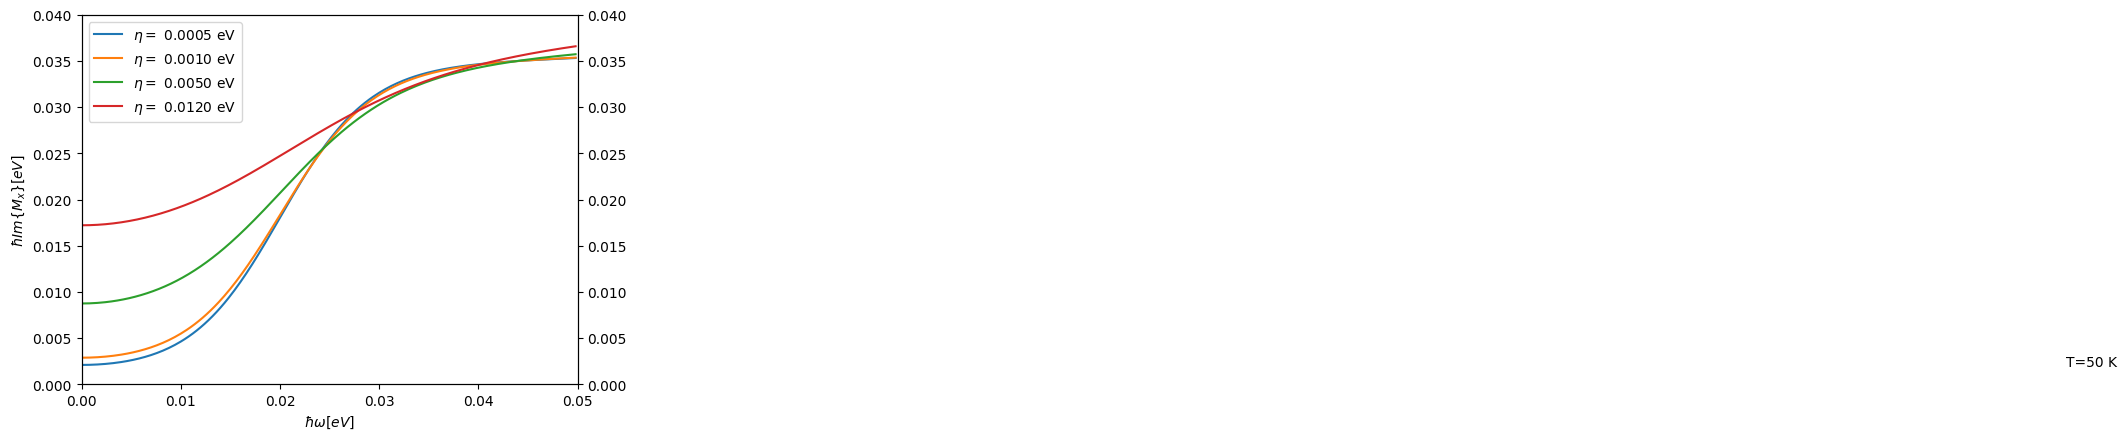

In [63]:
fig, *axs = setup_plot(real=False)
for eta in [0.0005, 0.001, 0.005, 0.012]:
    integrals = calculate_integral_points(mem_fn, eta=eta)
    plot_result(axs[0], integrals[1], eta=eta)
axs[0].legend(loc="best")
plt.text(0.20, 0.002 , f"T={T_0} K" , fontsize =10)
fig.tight_layout()

Podintegralna funkcija za memorijsku funkciju

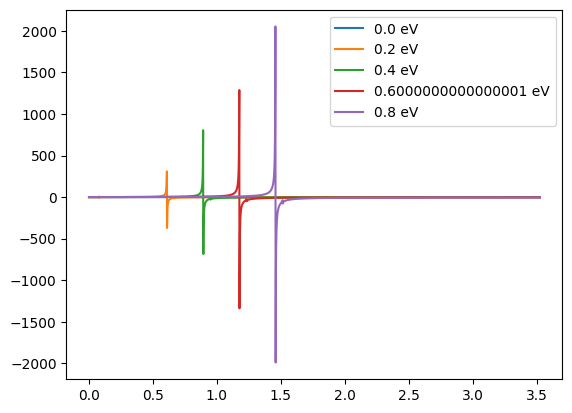

In [85]:
ws = np.arange(0, 1, 0.2)
ks = np.arange(0, Kf_*10, 0.001)
for w in ws:
    ss_sums = []
    for k in ks:
        ss = ss_sum_real(k, w, hbar_w_op, T_0, chemical_potential(T), eta_0)
        ss_sums.append(ss)
    plt.plot(ks, ss_sums, label = f"{w} eV")
plt.legend()

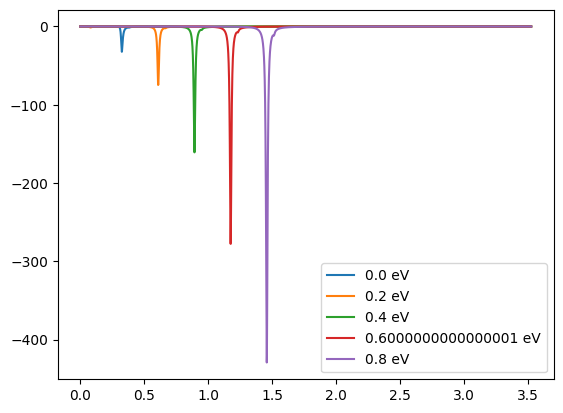

In [19]:
for w in ws:
    ss_sums = []
    for k in ks:
        ss = ss_sum_imag(k, w, hbar_w_op, T_0, chemical_potential(T), eta_0)
        ss_sums.append(ss)
    plt.plot(ks, ss_sums, label = f"{w} eV")
plt.legend()

## Akustični fononi

In [75]:
def ss_sum_part(K, theta, hbar_w, hbar_w_ph, T, u, eta):
    def summand(s1, s2):
        abs_K = sqrt(K**2 + Kf_**2 - 2 * Kf_ * K * cos(theta))
        factor = 1 - K * cos(theta) * Ef / eps(K) / Kf_
        return (bose_einstein(hbar_w_ph * abs_K, T) + fermi_dirac(s1 * s2 * eps(K), s1 * s2 * u, T)) / (hbar_w + s1 * Ef - s1 * eps(K) + s2 * hbar_w_ph * abs_K + eta * 1j) * abs_K * factor
    sum = 0
    for s1, s2 in itertools.product([-1,1], [-1, 1]):
        sum = sum + summand(s1, s2)
    return sum * K**2 * sin(theta)

def ss_sum_real(K, theta, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part(K, theta, hbar_w, hbar_w_ph, T, u, eta).real

def ss_sum_imag(K, theta, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part(K, theta, hbar_w, hbar_w_ph, T, u, eta).imag

def mem_fn_ac(ss_sum_fn, hbar_w, hbar_w_ph, u, T, eta):
    integral_k_theta_phi = integrate.nquad(ss_sum_fn, ([0, Kf_*6], [0, pi]), args=(hbar_w, hbar_w_ph, T, u, eta), opts={"epsabs": 1.49*10**(-4), "epsrel": 1.49*10**(-4)})[0]
    return -G_ac2 * integral_k_theta_phi/ (2*pi)**3 * 2*pi


**Memorijska funkcija**

c:\Users\Patrik\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
c:\Users\Patrik\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


KeyboardInterrupt: 

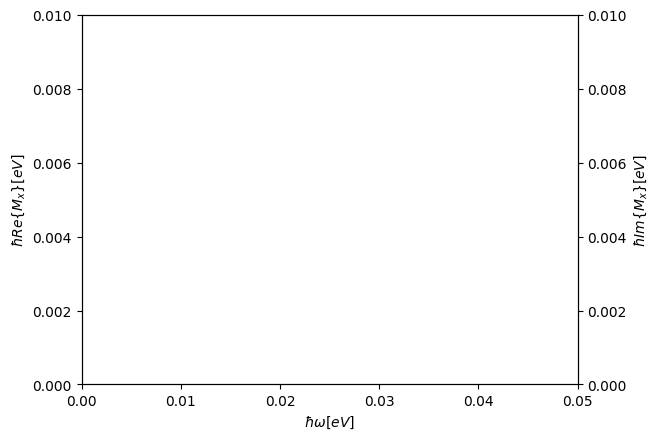

In [78]:
fig, *axs = setup_plot(y_lim=[0,0.01])
integrals = calculate_integral_points(mem_fn_ac)
plot_real_and_imag_result(*axs, *integrals, T=T_0)
axs[0].legend(loc="best")
fig.tight_layout()

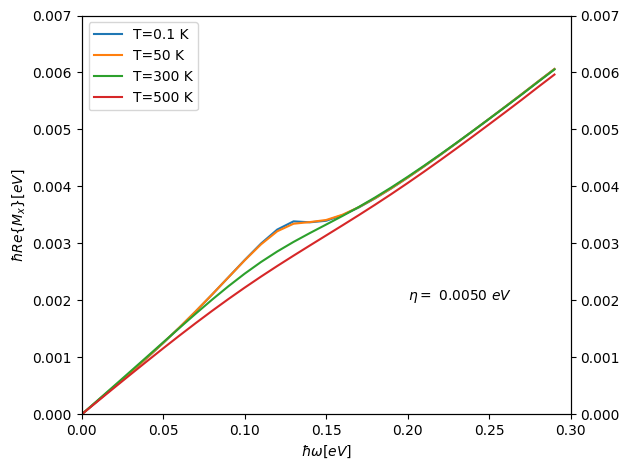

In [24]:
fig, *axs = setup_plot(imag=False, y_lim=[0,0.007])
for T in [0.1, 50, 300, 500]:
    integrals = calculate_integral_points(mem_fn_ac, T=T, ws=np.arange(0,0.3,0.01))
    plot_result(axs[0], integrals[0], T=T, ws=np.arange(0,0.3,0.01))
axs[0].legend(loc="best")
plt.text(0.20, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)
fig.tight_layout()

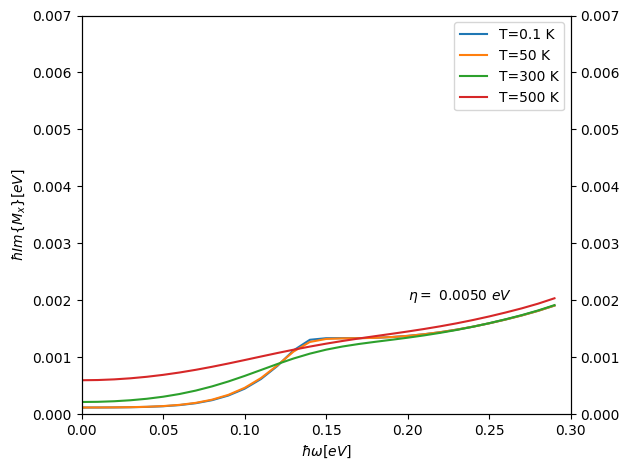

In [25]:
fig, *axs = setup_plot(real=False, y_lim=[0,0.007])
for T in [0.1, 50, 300, 500]:
    integrals = calculate_integral_points(mem_fn_ac, T=T, ws=np.arange(0,0.3,0.01))
    plot_result(axs[0], integrals[1], T=T, ws=np.arange(0,0.3,0.01))
axs[0].legend(loc="best")
plt.text(0.20, 0.002 , f"$\eta = $ {eta_0:.4f} $eV$" , fontsize =10)
fig.tight_layout()

0.001
0.005
0.012


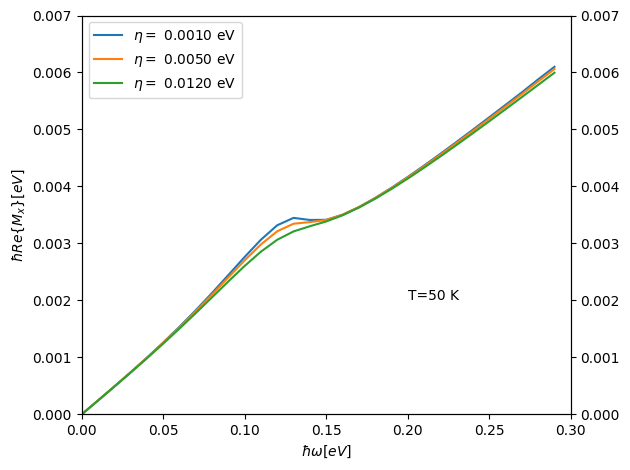

In [26]:
fig, *axs = setup_plot(imag=False, y_lim=[0,0.007])
for eta in [0.001, 0.005, 0.012]:
    integrals = calculate_integral_points(mem_fn_ac, eta=eta, ws=np.arange(0,0.3,0.01))
    plot_result(axs[0], integrals[0], eta=eta, ws=np.arange(0,0.3,0.01))
axs[0].legend(loc="best")
plt.text(0.20, 0.002 , f"T={T_0} K" , fontsize =10)
fig.tight_layout()

0.001
0.005
0.012


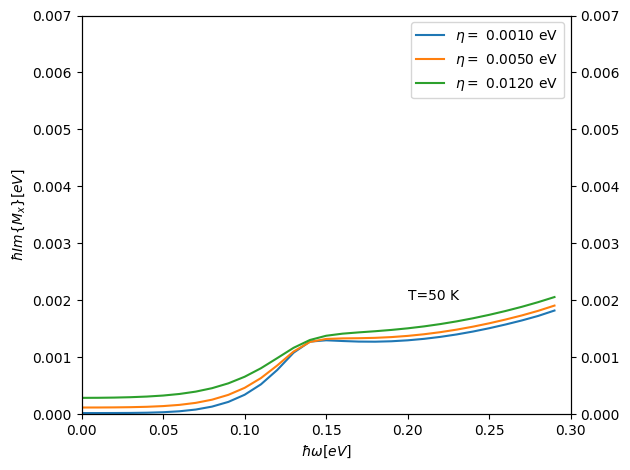

In [27]:
fig, *axs = setup_plot(real=False, y_lim=[0,0.007])
for eta in [0.001, 0.005, 0.012]:
    integrals = calculate_integral_points(mem_fn_ac, eta=eta, ws=np.arange(0,0.3,0.01))
    plot_result(axs[0], integrals[1], eta=eta, ws=np.arange(0,0.3,0.01))
axs[0].legend(loc="best")
plt.text(0.20, 0.002 , f"T={T_0} K" , fontsize =10)
fig.tight_layout()